# Table of Contents
1.[Introduction](#1)
2. [Data preprocessing](#2)
  * [Data overview](#3)
  * [Study and  replace/remove missing values](#5)
  * [Convert types](#4)
  * [Remove duplicate values](#7)
3. [Exploratory data analysis](#9)
  * [Study and remove outliers](#10)
  * [Find the Operators that have large number of missed incoming calls](#11)
  * [Find the Operators that have long waiting time for incoming calls](#12)
  * [Find the Operators that supposed to make outgoing calls and make small number of them](#13)
  * [Identifying Ineffective Operators](#14)
4. [Test statistical hypotheses](#15)
  * [Testing first hypothesis](#16)
  * [Testing second hypothesis](#17)
  * [Testing third hypothesis](#18)
  * [Testing final hypothesis](#19)
5. [Conclusion and recomedations.](#20)
6. [Dashboard](#21)
7. [Sources](#22)
8. [Presentation](#23)

<a id="1"></a> 
# Introduction

In this project I will analyze the CallMeMaybe dataset, in order to identify ineffective operators. We believe that operators considered ineffective if:
1. They have a large number of missed incoming calls (internal and external).
2. They have long waiting time for incoming calls (internal and external). 
3. They make small number of outgoing calls (only for the operators that supposed to make outgoing calls).
First, I will identify the ineffective operators, base on the Criterias above.
Then I will conducte statistical tests to check if my identification is valid, and the differendes between the groups are significant.
After that I will test my final hypothesis, that costumers of ineffective operators leave sooner than costumers of effective operators.

<a id="2"></a> 
# Data preprocessing

<a id="3"></a> 
## Data overview

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import scipy.stats as stats
from plotly import graph_objects as go
import datetime
from datetime import datetime
import matplotlib.dates as mdates

In [2]:
import math
from scipy import stats as st
import numpy as np
import math as mth

In [3]:
clients = pd.read_csv("/datasets/telecom_clients_us.csv")
dataset = pd.read_csv("/datasets/telecom_dataset_us.csv") 

In [4]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [5]:
dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [6]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


### conclusion:
The clients table - I don't see any missing data, I just need to convert the "date_start" colume to datatime type.
The dataset table - I see there is missing data in the "internal" and "operator_id" columns, I'll have to check it carfully. Again, I  need to convert the "date" colume to datatime type. I also not sure why the "operator_id" column is in "float" type, seems like it should be "int" type.

<a id="5"></a> 
## Study and replace/remove missing values

In [8]:
dataset.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [9]:
dataset.isna().sum()/len(dataset)*100

user_id                 0.000000
date                    0.000000
direction               0.000000
internal                0.217061
operator_id            15.160847
is_missed_call          0.000000
calls_count             0.000000
call_duration           0.000000
total_call_duration     0.000000
dtype: float64

The missing data in "internal" column is only 0.2% of the data, i'll drop it:

In [10]:
dataset = dataset.dropna(subset=['internal'])
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53785 non-null int64
date                   53785 non-null object
direction              53785 non-null object
internal               53785 non-null object
operator_id            45670 non-null float64
is_missed_call         53785 non-null bool
calls_count            53785 non-null int64
call_duration          53785 non-null int64
total_call_duration    53785 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.7+ MB


None

Now let's see what we can do with the missing data in 'operator_id' column. 
First i'll check if there are customers with only one operator per date. If there are such customers, and they have missing data in the operator_id in spesific date, i'll fill it with the id of their exclusive operator at this date:

In [11]:
operator_per_user_per_date = dataset.groupby(['user_id','date'])['operator_id'].nunique().reset_index()
operator_per_user_per_date = operator_per_user_per_date.rename(columns={'operator_id': 'operator_count'})
display(operator_per_user_per_date.head())

,user_id,date,operator_count
0,166377,2019-08-04 00:00:00+03:00,0
1,166377,2019-08-05 00:00:00+03:00,2
2,166377,2019-08-06 00:00:00+03:00,2
3,166377,2019-08-07 00:00:00+03:00,3
4,166377,2019-08-08 00:00:00+03:00,1


In [12]:
users_with_1_operator_per_date = operator_per_user_per_date[operator_per_user_per_date['operator_count']==1]
users_with_1_operator_per_date = users_with_1_operator_per_date.drop('operator_count',axis=1)
display(users_with_1_operator_per_date.head())

,user_id,date
4,166377,2019-08-08 00:00:00+03:00
6,166377,2019-08-12 00:00:00+03:00
87,166391,2019-08-06 00:00:00+03:00
88,166391,2019-08-07 00:00:00+03:00
96,166391,2019-09-23 00:00:00+03:00


In [13]:
print("Number of users with only 1 operator per date:", len(users_with_1_operator_per_date))

Number of users with only 1 operator per date: 4776


In [14]:
nanless_dataset = dataset.dropna()
print(nanless_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 9 columns):
user_id                45670 non-null int64
date                   45670 non-null object
direction              45670 non-null object
internal               45670 non-null object
operator_id            45670 non-null float64
is_missed_call         45670 non-null bool
calls_count            45670 non-null int64
call_duration          45670 non-null int64
total_call_duration    45670 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.2+ MB
None


In [15]:
users_operator_nanless = nanless_dataset[['date','user_id', 'operator_id']]
users_operator_nanless = users_operator_nanless.drop_duplicates()
display(users_operator_nanless.head())

,date,user_id,operator_id
1,2019-08-05 00:00:00+03:00,166377,880022.0
2,2019-08-05 00:00:00+03:00,166377,880020.0
10,2019-08-06 00:00:00+03:00,166377,881278.0
11,2019-08-06 00:00:00+03:00,166377,880020.0
14,2019-08-07 00:00:00+03:00,166377,880028.0


In [16]:
users_with_1_operator_per_date = users_with_1_operator_per_date.merge(users_operator_nanless, on=['user_id','date'], how='left')
display(users_with_1_operator_per_date.head())

,user_id,date,operator_id
0,166377,2019-08-08 00:00:00+03:00,880022.0
1,166377,2019-08-12 00:00:00+03:00,880028.0
2,166391,2019-08-06 00:00:00+03:00,882476.0
3,166391,2019-08-07 00:00:00+03:00,882478.0
4,166391,2019-09-23 00:00:00+03:00,882476.0


In [17]:
dataset = dataset.merge(users_with_1_operator_per_date, on=['user_id','date'], how='left')
display(dataset.head())

,user_id,date,direction,internal,operator_id_x,is_missed_call,calls_count,call_duration,total_call_duration,operator_id_y
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,NaN
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,NaN
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,NaN
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,NaN
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,NaN


In [18]:
dataset['operator_id_x'] = dataset['operator_id_x'].fillna(dataset['operator_id_y'])
dataset = dataset.drop('operator_id_y',axis=1)
dataset = dataset.rename(columns={'operator_id_x': 'operator_id'})
display(dataset.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [19]:
dataset['operator_id'].isna().sum()

5558

In [20]:
dataset['operator_id'].isna().sum()/len(dataset)*100

10.33373617179511

We still have 5,558 missing data (10% of the data).  I can't think of a way to predict the missing operator_id, so I decided to drop the missing values.

In [21]:
len(dataset)

53785

In [22]:
dataset = dataset.dropna()

In [23]:
len(dataset)

48227

In [24]:
dataset['operator_id'].drop_duplicates().count()

1092

We have 1092 different operators.

In [25]:
dataset['user_id'].drop_duplicates().count()

290

We have 290 different clients.

<a id="4"></a> 
## Convert types

I already converted the 'date' column in the dataset table at the prior part, so I only need to convert the 'operator_id' column and the 'date_start' column (from the clients table):

In [26]:
dataset['date'] = dataset['date'].values.astype('datetime64[D]')
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48227 entries, 1 to 53783
Data columns (total 9 columns):
user_id                48227 non-null int64
date                   48227 non-null datetime64[ns]
direction              48227 non-null object
internal               48227 non-null object
operator_id            48227 non-null float64
is_missed_call         48227 non-null bool
calls_count            48227 non-null int64
call_duration          48227 non-null int64
total_call_duration    48227 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.4+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



None

In [27]:
dataset['operator_id'] = dataset['operator_id'].astype('int')
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48227 entries, 1 to 53783
Data columns (total 9 columns):
user_id                48227 non-null int64
date                   48227 non-null datetime64[ns]
direction              48227 non-null object
internal               48227 non-null object
operator_id            48227 non-null int64
is_missed_call         48227 non-null bool
calls_count            48227 non-null int64
call_duration          48227 non-null int64
total_call_duration    48227 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(5), object(2)
memory usage: 3.4+ MB


None

In [28]:
clients['date_start'] =  clients['date_start'].values.astype('datetime64[D]')
display(clients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


None

<a id="7"></a> 
## Remove duplicate values

In [29]:
dataset.duplicated().sum()

4392

In [30]:
dataset.duplicated().sum()/len(dataset)*100

9.106931801687852

There are 4392 duplicates! lets drop it:

In [31]:
dataset = dataset.drop_duplicates()

In [32]:
dataset.duplicated().sum()

0

### conclusion:
At First we had 15% missing data in the 'operator_id' column. I filled in partially: for users that had only 1 operator per date, I filled the missing value with the id of the operator they had in this date.
After that we remained with 10% missing data that I decided to drop, since I did not find reasonable way to fill it.
I also droped 4,392 duplicates I found.

<a id="9"></a> 
# Exploratory data analysis

<a id="10"></a> 
## Study and remove outliers

I will start with the "calls_count" column:

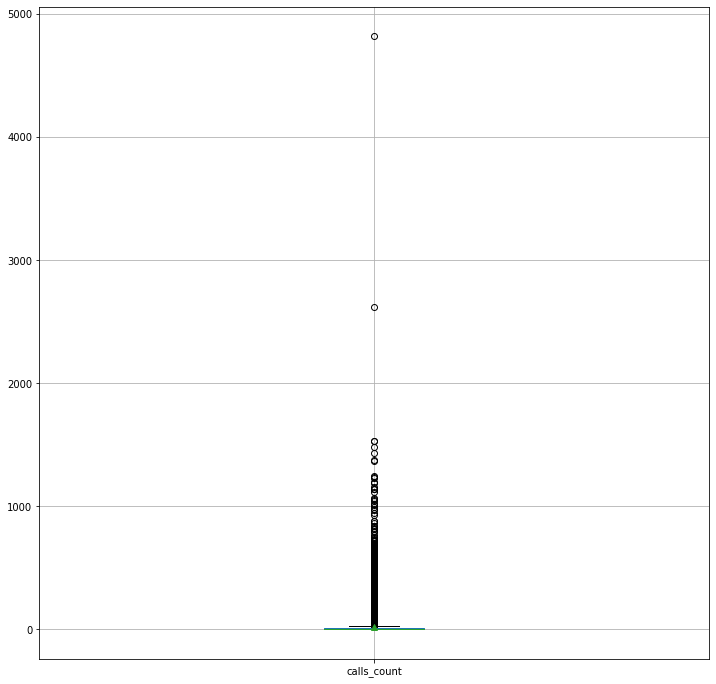

In [33]:
dataset.boxplot(column='calls_count', showmeans=True, figsize=(12,12))

(0, 100)

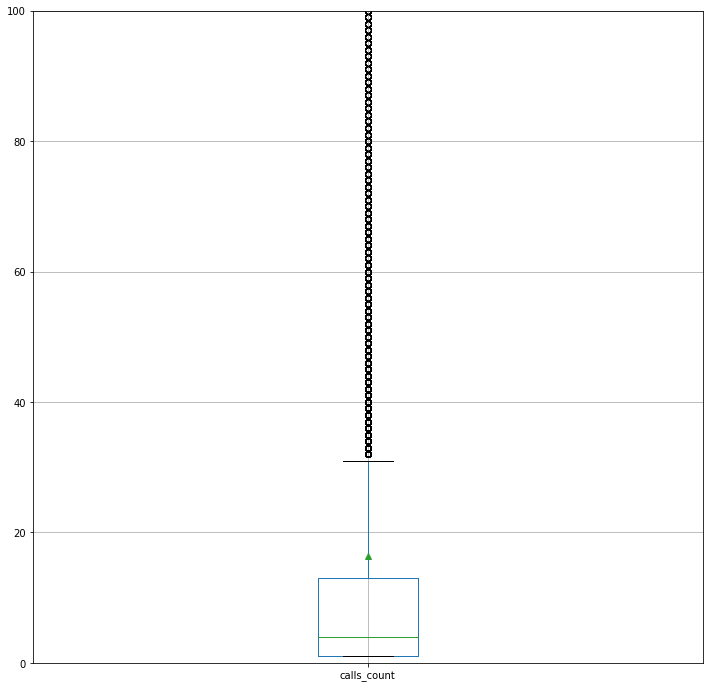

In [34]:
dataset.boxplot(column='calls_count', showmeans=True, figsize=(12,12))
plt.ylim(0, 100)

(0, 35)

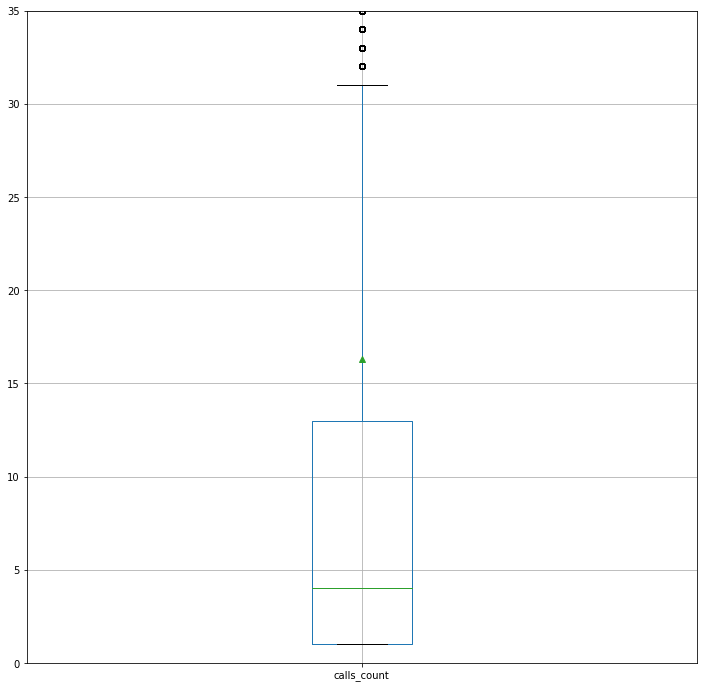

In [35]:
dataset.boxplot(column='calls_count', showmeans=True, figsize=(12,12))
plt.ylim(0, 35)

In [36]:
len(dataset[dataset['calls_count']>32])/len(dataset)*100

11.043686551842136

In [37]:
len(dataset[dataset['calls_count']>150])/len(dataset)*100

1.0927341165735143

I'll delete only 1% of the data - rows with more than 150 calls (I don't think it make sense that users do more than 150 calls a day).

In [38]:
dataset = dataset[dataset['calls_count']<150]

Let's move to the "calls_count" column. First, I will create new columns with the duration per call.

In [39]:
dataset['call_duration_per_call'] = dataset['call_duration'] / dataset['calls_count']
dataset['total_call_duration_per_call'] = dataset['total_call_duration'] / dataset['calls_count']

In [40]:
dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_duration_per_call,total_call_duration_per_call
1,166377,2019-08-04,out,True,880022,True,3,0,5,0.0,1.666667
2,166377,2019-08-04,out,True,880020,True,1,0,1,0.0,1.000000
3,166377,2019-08-04,out,True,880020,False,1,10,18,10.0,18.000000
4,166377,2019-08-04,out,False,880022,True,3,0,25,0.0,8.333333
5,166377,2019-08-04,out,False,880020,False,2,3,29,1.5,14.500000


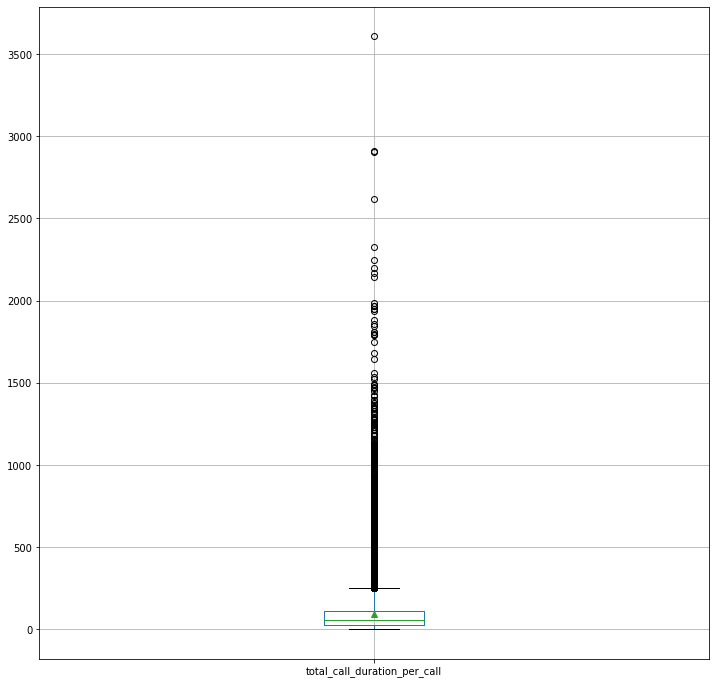

In [41]:
dataset.boxplot(column='total_call_duration_per_call', showmeans=True, figsize=(12,12))

In [42]:
len(dataset[dataset['total_call_duration_per_call']>500])/len(dataset)*100

1.5201845444059976

I'll delete only rows with "total_call_duration_per_call" higher than 500 (1.5% of the data).

In [43]:
dataset = dataset[dataset['total_call_duration_per_call']<500]

In [44]:
len(dataset)

42691

<a id="11"></a> 
## Find the Operators that have large number of missed incoming calls

In [45]:
incoming_calls = dataset[dataset['direction']=="in"]
display(incoming_calls.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_duration_per_call,total_call_duration_per_call
26,166377,2019-08-11,in,False,880028,False,1,407,411,407.0,411.0
27,166377,2019-08-11,in,False,880028,True,2,0,34,0.0,17.0
34,166377,2019-08-12,in,False,880028,False,1,88,102,88.0,102.0
37,166377,2019-08-13,in,False,880026,False,2,197,218,98.5,109.0
39,166377,2019-08-13,in,False,880028,False,1,33,37,33.0,37.0


In [46]:
incoming_calls_per_operator = incoming_calls.groupby('operator_id')['calls_count'].sum().reset_index()
incoming_calls_per_operator = incoming_calls_per_operator[incoming_calls_per_operator['calls_count'] != 0]
display(incoming_calls_per_operator.head())
display(len(incoming_calls_per_operator))

,operator_id,calls_count
0,879896,59
1,879898,143
2,880020,7
3,880022,8
4,880026,24


798

In [47]:
missed_incoming_calls = dataset[(dataset['direction']=="in") & (dataset['is_missed_call']==True)]
missed_incoming_calls_per_operator = missed_incoming_calls.groupby('operator_id')['calls_count'].sum().reset_index()
display(missed_incoming_calls_per_operator.head())

,operator_id,calls_count
0,879896,2
1,879898,40
2,880028,2
3,882476,3
4,882478,2


In [48]:
percentage_missed_calls = incoming_calls_per_operator.merge(missed_incoming_calls_per_operator, on="operator_id", how="left")
display(percentage_missed_calls.head())
len(percentage_missed_calls)

,operator_id,calls_count_x,calls_count_y
0,879896,59,2.0
1,879898,143,40.0
2,880020,7,NaN
3,880022,8,NaN
4,880026,24,NaN


798

In [49]:
percentage_missed_calls = percentage_missed_calls.rename(columns={'calls_count_x': 'total_incoming_calls_count'})
percentage_missed_calls = percentage_missed_calls.rename(columns={'calls_count_y': 'missed_incoming_calls_count'})
percentage_missed_calls = percentage_missed_calls.fillna(0)
percentage_missed_calls['missed_incoming_calls_percentage'] = percentage_missed_calls['missed_incoming_calls_count']/percentage_missed_calls['total_incoming_calls_count']*100
percentage_missed_calls['general_percentage'] = percentage_missed_calls['missed_incoming_calls_count'].sum()/ percentage_missed_calls['total_incoming_calls_count'].sum()*100
percentage_missed_calls['distance_from_mean'] = percentage_missed_calls['missed_incoming_calls_percentage']-percentage_missed_calls['general_percentage']
display(percentage_missed_calls.head())

,operator_id,total_incoming_calls_count,missed_incoming_calls_count,missed_incoming_calls_percentage,general_percentage,distance_from_mean
0,879896,59,2.0,3.389831,12.20016,-8.810329
1,879898,143,40.0,27.972028,12.20016,15.771868
2,880020,7,0.0,0.000000,12.20016,-12.200160
3,880022,8,0.0,0.000000,12.20016,-12.200160
4,880026,24,0.0,0.000000,12.20016,-12.200160


In [50]:
percentage_missed_calls['distance_from_mean'].describe()

count    798.000000
mean       9.399175
std       31.086625
min      -12.200160
25%      -12.200160
50%       -8.438195
75%       21.133174
max       87.799840
Name: distance_from_mean, dtype: float64

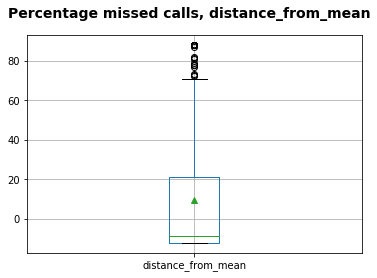

In [51]:
fig = plt.figure()
fig.suptitle('Percentage missed calls, distance_from_mean', fontsize=14, fontweight='bold')
percentage_missed_calls.boxplot(column='distance_from_mean', showmeans=True)

In [52]:
percentage_missed_calls["effectiveness"] = [3 if x<=-12 else 0 for x in percentage_missed_calls["distance_from_mean"]]
percentage_missed_calls.loc[(percentage_missed_calls['distance_from_mean'] >-12) & (percentage_missed_calls['distance_from_mean'] <=-8), 'effectiveness'] = 2
percentage_missed_calls.loc[(percentage_missed_calls['distance_from_mean'] >-8) & (percentage_missed_calls['distance_from_mean'] <=21), 'effectiveness'] = 1 
display(percentage_missed_calls.head())

,operator_id,total_incoming_calls_count,missed_incoming_calls_count,missed_incoming_calls_percentage,general_percentage,distance_from_mean,effectiveness
0,879896,59,2.0,3.389831,12.20016,-8.810329,2
1,879898,143,40.0,27.972028,12.20016,15.771868,1
2,880020,7,0.0,0.000000,12.20016,-12.200160,3
3,880022,8,0.0,0.000000,12.20016,-12.200160,3
4,880026,24,0.0,0.000000,12.20016,-12.200160,3


In [53]:
percentage_missed_calls['effectiveness'].value_counts()

3    291
0    205
1    186
2    116
Name: effectiveness, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41954d19d0>]],
      dtype=object)

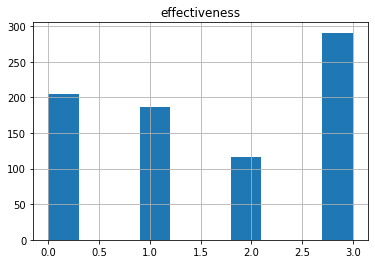

In [54]:
percentage_missed_calls.hist('effectiveness')

I divided the operators to "effectiveness" groups base on the percentage of missed incoming calls they had (with regard to the general percentage). 3 = most effective, 0 = least effective.

<a id="12"></a> 
## Find the Operators that have long waiting time for incoming calls

In [55]:
waiting_time = dataset[(dataset['direction']=="in") & (dataset['is_missed_call']==False)]
display(waiting_time.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_duration_per_call,total_call_duration_per_call
26,166377,2019-08-11,in,False,880028,False,1,407,411,407.0,411.0
34,166377,2019-08-12,in,False,880028,False,1,88,102,88.0,102.0
37,166377,2019-08-13,in,False,880026,False,2,197,218,98.5,109.0
39,166377,2019-08-13,in,False,880028,False,1,33,37,33.0,37.0
49,166377,2019-08-14,in,False,880028,False,1,23,27,23.0,27.0


In [56]:
total_duration_per_operator = waiting_time.groupby('operator_id')['total_call_duration_per_call'].sum().reset_index()
total_duration_per_operator = total_duration_per_operator[total_duration_per_operator['total_call_duration_per_call'] != 0]
display(total_duration_per_operator.head())
display(len(total_duration_per_operator))

,operator_id,total_call_duration_per_call
0,879896,1972.77193
1,879898,4521.80000
2,880020,353.00000
3,880022,624.00000
4,880026,1127.00000


747

In [57]:
call_duration_per_operator = waiting_time.groupby('operator_id')['call_duration_per_call'].sum().reset_index()
display(call_duration_per_operator.head())

,operator_id,call_duration_per_call
0,879896,1696.451754
1,879898,3726.233333
2,880020,299.000000
3,880022,512.000000
4,880026,1020.166667


In [58]:
percentage_call_duration = total_duration_per_operator.merge(call_duration_per_operator, on="operator_id", how="left")
display(percentage_call_duration.head())
len(percentage_call_duration)

,operator_id,total_call_duration_per_call,call_duration_per_call
0,879896,1972.77193,1696.451754
1,879898,4521.80000,3726.233333
2,880020,353.00000,299.000000
3,880022,624.00000,512.000000
4,880026,1127.00000,1020.166667


747

In [59]:
percentage_call_duration = percentage_call_duration.fillna(0)
percentage_call_duration['percentage_waiting_time'] = 100-(percentage_call_duration['call_duration_per_call']/percentage_call_duration['total_call_duration_per_call']*100)
percentage_call_duration['general_percentage'] = 100-(percentage_call_duration['call_duration_per_call'].sum()/ percentage_call_duration['total_call_duration_per_call'].sum()*100)
percentage_call_duration['distance_from_mean'] = percentage_call_duration['percentage_waiting_time']-percentage_call_duration['general_percentage']
display(percentage_call_duration.head())

,operator_id,total_call_duration_per_call,call_duration_per_call,percentage_waiting_time,general_percentage,distance_from_mean
0,879896,1972.77193,1696.451754,14.006696,13.738425,0.268271
1,879898,4521.80000,3726.233333,17.594026,13.738425,3.855601
2,880020,353.00000,299.000000,15.297450,13.738425,1.559025
3,880022,624.00000,512.000000,17.948718,13.738425,4.210293
4,880026,1127.00000,1020.166667,9.479444,13.738425,-4.258981


In [60]:
percentage_call_duration['distance_from_mean'].describe()

count    747.000000
mean       7.385628
std       16.782228
min      -13.175210
25%       -4.084278
50%        2.768466
75%       13.270716
max       82.261575
Name: distance_from_mean, dtype: float64

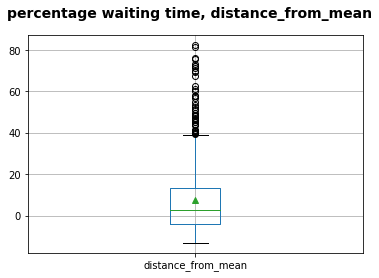

In [61]:
fig = plt.figure()
fig.suptitle('percentage waiting time, distance_from_mean', fontsize=14, fontweight='bold')
percentage_call_duration.boxplot(column='distance_from_mean', showmeans=True)

In [62]:
percentage_call_duration["effectiveness"] = [3 if x<=-4 else 0 for x in percentage_call_duration["distance_from_mean"]]
percentage_call_duration.loc[(percentage_call_duration['distance_from_mean'] >-4) & (percentage_call_duration['distance_from_mean'] <=2), 'effectiveness'] = 2
percentage_call_duration.loc[(percentage_call_duration['distance_from_mean'] >2) & (percentage_call_duration['distance_from_mean'] <=13), 'effectiveness'] = 1 
display(percentage_call_duration.head())

,operator_id,total_call_duration_per_call,call_duration_per_call,percentage_waiting_time,general_percentage,distance_from_mean,effectiveness
0,879896,1972.77193,1696.451754,14.006696,13.738425,0.268271,2
1,879898,4521.80000,3726.233333,17.594026,13.738425,3.855601,1
2,880020,353.00000,299.000000,15.297450,13.738425,1.559025,2
3,880022,624.00000,512.000000,17.948718,13.738425,4.210293,1
4,880026,1127.00000,1020.166667,9.479444,13.738425,-4.258981,3


In [63]:
percentage_call_duration['effectiveness'].value_counts()

1    200
3    190
0    188
2    169
Name: effectiveness, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41953dad50>]],
      dtype=object)

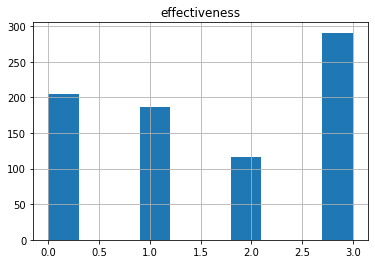

In [64]:
percentage_missed_calls.hist('effectiveness')

I divided the operators to "effectiveness" groups base on the percentage of waiting time of their incoming calls (with regard to the general percentage). 3 = most effective, 0 = least effective.

<a id="13"></a> 
## Find the Operators that supposed to make outgoing calls and make small number of them

In [65]:
all_calls_per_operator = dataset.groupby('operator_id')['calls_count'].sum().reset_index()
all_calls_per_operator = all_calls_per_operator.rename(columns={'calls_count': 'total_calls_count'})
all_calls_per_operator = all_calls_per_operator.dropna()
display(all_calls_per_operator.head())

,operator_id,total_calls_count
0,879896,926
1,879898,7196
2,880020,45
3,880022,193
4,880026,2232


In [66]:
outgoing_calls = dataset[(dataset['direction']=="out") & (dataset['internal']==False)]
display(outgoing_calls.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_duration_per_call,total_call_duration_per_call
4,166377,2019-08-04,out,False,880022,True,3,0,25,0.0,8.333333
5,166377,2019-08-04,out,False,880020,False,2,3,29,1.5,14.500000
6,166377,2019-08-04,out,False,880020,True,8,0,50,0.0,6.250000
10,166377,2019-08-05,out,False,881278,True,3,0,29,0.0,9.666667
11,166377,2019-08-05,out,False,880020,True,5,0,70,0.0,14.000000


In [67]:
outgoing_calls_per_operator = outgoing_calls.groupby('operator_id')['calls_count'].sum().reset_index()
outgoing_calls_per_operator = outgoing_calls_per_operator.rename(columns={'calls_count': 'outgoing_calls_count'})
display(outgoing_calls_per_operator.head())
display(len(outgoing_calls_per_operator))

,operator_id,outgoing_calls_count
0,879896,811
1,879898,7035
2,880020,34
3,880022,170
4,880026,2188


830

In [68]:
percentage_outgoing_calls = outgoing_calls_per_operator.merge(all_calls_per_operator, on="operator_id", how="left")
display(percentage_outgoing_calls.head())
display(len(percentage_outgoing_calls))

,operator_id,outgoing_calls_count,total_calls_count
0,879896,811,926
1,879898,7035,7196
2,880020,34,45
3,880022,170,193
4,880026,2188,2232


830

In [69]:
percentage_outgoing_calls['percentage_outgoing_calls'] = percentage_outgoing_calls['outgoing_calls_count']/percentage_outgoing_calls['total_calls_count']*100
percentage_outgoing_calls['general_percentage'] = percentage_outgoing_calls['outgoing_calls_count'].sum()/ percentage_outgoing_calls['total_calls_count'].sum()*100
percentage_outgoing_calls['distance_from_mean'] = percentage_outgoing_calls['percentage_outgoing_calls']-percentage_outgoing_calls['general_percentage']
display(percentage_outgoing_calls.head())

,operator_id,outgoing_calls_count,total_calls_count,percentage_outgoing_calls,general_percentage,distance_from_mean
0,879896,811,926,87.580994,79.421077,8.159916
1,879898,7035,7196,97.762646,79.421077,18.341569
2,880020,34,45,75.555556,79.421077,-3.865522
3,880022,170,193,88.082902,79.421077,8.661824
4,880026,2188,2232,98.028674,79.421077,18.607597


In [70]:
percentage_outgoing_calls['distance_from_mean'].describe()

count    830.000000
mean     -11.767830
std       32.496762
min      -79.313086
25%      -34.675932
50%       -2.512212
75%       19.503033
max       20.578923
Name: distance_from_mean, dtype: float64

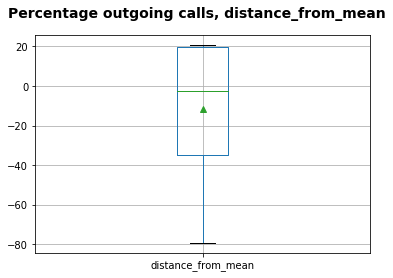

In [71]:
fig = plt.figure()
fig.suptitle('Percentage outgoing calls, distance_from_mean', fontsize=14, fontweight='bold')
percentage_outgoing_calls.boxplot(column='distance_from_mean', showmeans=True)

In [72]:
percentage_outgoing_calls["effectiveness"] = [3 if x>=19.5 else 0 for x in percentage_outgoing_calls["distance_from_mean"]]
percentage_outgoing_calls.loc[(percentage_outgoing_calls['distance_from_mean'] <19.5) & (percentage_outgoing_calls['distance_from_mean'] >=-2.5), 'effectiveness'] = 2
percentage_outgoing_calls.loc[(percentage_outgoing_calls['distance_from_mean'] <-2.5) & (percentage_outgoing_calls['distance_from_mean'] >=-34.67), 'effectiveness'] = 1 
display(percentage_outgoing_calls.head())

,operator_id,outgoing_calls_count,total_calls_count,percentage_outgoing_calls,general_percentage,distance_from_mean,effectiveness
0,879896,811,926,87.580994,79.421077,8.159916,2
1,879898,7035,7196,97.762646,79.421077,18.341569,2
2,880020,34,45,75.555556,79.421077,-3.865522,1
3,880022,170,193,88.082902,79.421077,8.661824,2
4,880026,2188,2232,98.028674,79.421077,18.607597,2


In [73]:
percentage_outgoing_calls['effectiveness'].value_counts()

3    209
0    208
1    207
2    206
Name: effectiveness, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41956d2350>]],
      dtype=object)

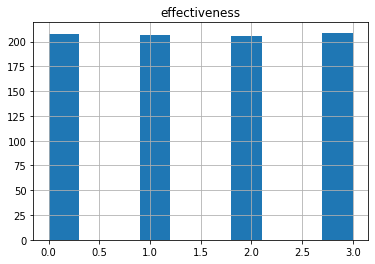

In [74]:
percentage_outgoing_calls.hist('effectiveness')

I divided the operators to "effectiveness" groups base on the percentage of external outgoing calls they had (with regard to the general percentage). 3 = most effective, 0 = least effective. 

<a id="14"></a> 
## Identifying Ineffective Operators

In [75]:
operators = dataset['operator_id'].drop_duplicates().reset_index()
display(operators.head())

,index,operator_id
0,1,880022
1,2,880020
2,10,881278
3,14,880028
4,15,880026


In [76]:
percentage_missed_calls

,operator_id,total_incoming_calls_count,missed_incoming_calls_count,missed_incoming_calls_percentage,general_percentage,distance_from_mean,effectiveness
0,879896,59,2.0,3.389831,12.20016,-8.810329,2
1,879898,143,40.0,27.972028,12.20016,15.771868,1
2,880020,7,0.0,0.000000,12.20016,-12.200160,3
3,880022,8,0.0,0.000000,12.20016,-12.200160,3
4,880026,24,0.0,0.000000,12.20016,-12.200160,3
...,...,...,...,...,...,...,...
793,971102,111,35.0,31.531532,12.20016,19.331372,1
794,971354,11,5.0,45.454545,12.20016,33.254386,0
795,972412,1,0.0,0.000000,12.20016,-12.200160,3
796,972460,2,1.0,50.000000,12.20016,37.799840,0


In [77]:
operators = operators.merge(percentage_missed_calls, on="operator_id", how="left")
operators = operators.rename(columns={'effectiveness': 'effectiveness: missed_incoming_calls'})
display(operators.head())

,index,operator_id,total_incoming_calls_count,missed_incoming_calls_count,missed_incoming_calls_percentage,general_percentage,distance_from_mean,effectiveness: missed_incoming_calls
0,1,880022,8.0,0.0,0.000000,12.20016,-12.200160,3.0
1,2,880020,7.0,0.0,0.000000,12.20016,-12.200160,3.0
2,10,881278,NaN,NaN,NaN,NaN,NaN,NaN
3,14,880028,65.0,2.0,3.076923,12.20016,-9.123237,2.0
4,15,880026,24.0,0.0,0.000000,12.20016,-12.200160,3.0


In [78]:
operators = operators.drop(['total_incoming_calls_count', 'missed_incoming_calls_count', 'missed_incoming_calls_percentage', 'general_percentage', 'distance_from_mean'], axis = 1)
display(operators.head())

,index,operator_id,effectiveness: missed_incoming_calls
0,1,880022,3.0
1,2,880020,3.0
2,10,881278,NaN
3,14,880028,2.0
4,15,880026,3.0


In [79]:
operators = operators.merge(percentage_call_duration, on="operator_id", how="left")
operators = operators.rename(columns={'effectiveness': 'effectiveness: waiting_time'})
display(operators.head())

,index,operator_id,effectiveness: missed_incoming_calls,total_call_duration_per_call,call_duration_per_call,percentage_waiting_time,general_percentage,distance_from_mean,effectiveness: waiting_time
0,1,880022,3.0,624.0,512.000000,17.948718,13.738425,4.210293,1.0
1,2,880020,3.0,353.0,299.000000,15.297450,13.738425,1.559025,2.0
2,10,881278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14,880028,2.0,3852.2,3601.833333,6.499316,13.738425,-7.239109,3.0
4,15,880026,3.0,1127.0,1020.166667,9.479444,13.738425,-4.258981,3.0


In [80]:
operators = operators.drop(['total_call_duration_per_call', 'call_duration_per_call', 'percentage_waiting_time', 'general_percentage', 'distance_from_mean'], axis = 1)
display(operators.head())

,index,operator_id,effectiveness: missed_incoming_calls,effectiveness: waiting_time
0,1,880022,3.0,1.0
1,2,880020,3.0,2.0
2,10,881278,NaN,NaN
3,14,880028,2.0,3.0
4,15,880026,3.0,3.0


In [81]:
operators = operators.merge(percentage_outgoing_calls, on="operator_id", how="left")
operators = operators.rename(columns={'effectiveness': 'effectiveness: outgoing_calls'})
display(operators.head())

,index,operator_id,effectiveness: missed_incoming_calls,effectiveness: waiting_time,outgoing_calls_count,total_calls_count,percentage_outgoing_calls,general_percentage,distance_from_mean,effectiveness: outgoing_calls
0,1,880022,3.0,1.0,170.0,193.0,88.082902,79.421077,8.661824,2.0
1,2,880020,3.0,2.0,34.0,45.0,75.555556,79.421077,-3.865522,1.0
2,10,881278,NaN,NaN,12.0,20.0,60.000000,79.421077,-19.421077,1.0
3,14,880028,2.0,3.0,2489.0,2562.0,97.150664,79.421077,17.729586,2.0
4,15,880026,3.0,3.0,2188.0,2232.0,98.028674,79.421077,18.607597,2.0


In [82]:
operators = operators.drop(['outgoing_calls_count', 'total_calls_count', 'percentage_outgoing_calls', 'general_percentage', 'distance_from_mean'], axis = 1)
display(operators.head())

,index,operator_id,effectiveness: missed_incoming_calls,effectiveness: waiting_time,effectiveness: outgoing_calls
0,1,880022,3.0,1.0,2.0
1,2,880020,3.0,2.0,1.0
2,10,881278,NaN,NaN,1.0
3,14,880028,2.0,3.0,2.0
4,15,880026,3.0,3.0,2.0


In [83]:
display(operators.isna().sum())

index                                     0
operator_id                               0
effectiveness: missed_incoming_calls    292
effectiveness: waiting_time             343
effectiveness: outgoing_calls           260
dtype: int64

I will fill the missing data in column "effectiveness: missed_incoming_calls" with 3, because if the we don't have data on operators it means that they didn't have missing calls.

In [84]:
operators['effectiveness: missed_incoming_calls'] = operators['effectiveness: missed_incoming_calls'].fillna(3)
display(operators.head())

,index,operator_id,effectiveness: missed_incoming_calls,effectiveness: waiting_time,effectiveness: outgoing_calls
0,1,880022,3.0,1.0,2.0
1,2,880020,3.0,2.0,1.0
2,10,881278,3.0,NaN,1.0
3,14,880028,2.0,3.0,2.0
4,15,880026,3.0,3.0,2.0


In [85]:
display(operators.isna().sum())

index                                     0
operator_id                               0
effectiveness: missed_incoming_calls      0
effectiveness: waiting_time             343
effectiveness: outgoing_calls           260
dtype: int64

I won't change the missing data in column "effectiveness: waiting_time", because if operators have missing data in this column it means that they didn't got calls so I can't rate them. I also won't change the missing data in "effectiveness: outgoing_calls" column, since not all the operators need to make outgoing calls.

In [86]:
operators['total'] = (operators['effectiveness: missed_incoming_calls'] + operators['effectiveness: waiting_time'] + operators['effectiveness: outgoing_calls'])/3
display(operators.head())

,index,operator_id,effectiveness: missed_incoming_calls,effectiveness: waiting_time,effectiveness: outgoing_calls,total
0,1,880022,3.0,1.0,2.0,2.000000
1,2,880020,3.0,2.0,1.0,2.000000
2,10,881278,3.0,NaN,1.0,NaN
3,14,880028,2.0,3.0,2.0,2.333333
4,15,880026,3.0,3.0,2.0,2.666667


In [87]:
operators['total'] = operators['total'].fillna((operators['effectiveness: missed_incoming_calls'] + operators['effectiveness: waiting_time'])/2)
operators['total'] = operators['total'].fillna((operators['effectiveness: missed_incoming_calls'] + operators['effectiveness: outgoing_calls'])/2)
display(operators.head())                              

,index,operator_id,effectiveness: missed_incoming_calls,effectiveness: waiting_time,effectiveness: outgoing_calls,total
0,1,880022,3.0,1.0,2.0,2.000000
1,2,880020,3.0,2.0,1.0,2.000000
2,10,881278,3.0,NaN,1.0,2.000000
3,14,880028,2.0,3.0,2.0,2.333333
4,15,880026,3.0,3.0,2.0,2.666667


In [88]:
operators['effectiveness: total'] = ["low" if x<=1 else "high" for x in operators["total"]]
operators.loc[(operators['total'] >1) & (operators['total'] <=2), 'effectiveness: total'] = "medium"
display(operators['effectiveness: total'].value_counts())

medium    420
high      370
low       300
Name: effectiveness: total, dtype: int64

In [89]:
display(operators.head())

,index,operator_id,effectiveness: missed_incoming_calls,effectiveness: waiting_time,effectiveness: outgoing_calls,total,effectiveness: total
0,1,880022,3.0,1.0,2.0,2.000000,medium
1,2,880020,3.0,2.0,1.0,2.000000,medium
2,10,881278,3.0,NaN,1.0,2.000000,medium
3,14,880028,2.0,3.0,2.0,2.333333,high
4,15,880026,3.0,3.0,2.0,2.666667,high


In [90]:
operators_final = operators.drop(['index', 'effectiveness: missed_incoming_calls', 'effectiveness: waiting_time', 'effectiveness: outgoing_calls', 'total'], axis = 1)
display(operators_final.head())

,operator_id,effectiveness: total
0,880022,medium
1,880020,medium
2,881278,medium
3,880028,high
4,880026,high


In [91]:
operators_final.isna().sum()

operator_id             0
effectiveness: total    0
dtype: int64

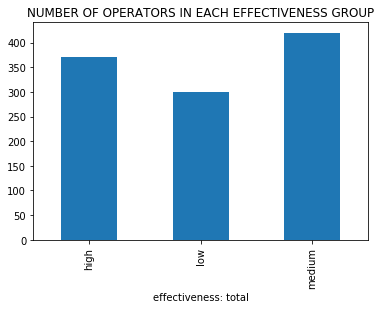

In [92]:
operators_final.groupby('effectiveness: total')['operator_id'].nunique().plot(kind='bar', title="NUMBER OF OPERATORS IN EACH EFFECTIVENESS GROUP")

In [93]:
operators_final[operators_final['effectiveness: total']=='low']['operator_id'].drop_duplicates().to_list()

[882476,
 882478,
 886892,
 891900,
 886674,
 902510,
 939478,
 888534,
 888532,
 882680,
 884294,
 934076,
 934074,
 887280,
 884412,
 884408,
 906680,
 925106,
 885682,
 884946,
 884478,
 884524,
 900194,
 908834,
 908960,
 908958,
 946468,
 889638,
 893420,
 893400,
 893402,
 886146,
 892798,
 897872,
 890582,
 887416,
 891162,
 889640,
 888406,
 891744,
 891746,
 950444,
 898892,
 899082,
 891252,
 891970,
 891254,
 891918,
 903390,
 895170,
 894232,
 894224,
 894230,
 891824,
 895266,
 894120,
 892530,
 892536,
 892532,
 892534,
 891946,
 893172,
 900614,
 955820,
 901350,
 910226,
 913886,
 910038,
 930242,
 895140,
 895598,
 896538,
 903512,
 895776,
 895578,
 895576,
 894656,
 896010,
 896018,
 895786,
 906396,
 906392,
 906402,
 906400,
 906408,
 906410,
 906412,
 906416,
 954750,
 910594,
 972460,
 896390,
 900742,
 900746,
 898560,
 898558,
 898422,
 914630,
 914626,
 909134,
 904284,
 901178,
 903312,
 900492,
 901492,
 898906,
 898434,
 916424,
 903292,
 911102,
 911142,
 

I created a colum that sums the result from prior steps and based on this column I categorized the operators to 3 effectiveness groups: high, medium and low. please pay attention that not all of the operators have been categorized, only the ones that had values in at least 2 parameters (missed_incoming_calls, waiting_time, effectiveness: outgoing_calls).

<a id="15"></a>
# Test statistical hypotheses

<a id="16"></a>
## Testing first hypothesis

Null hypothesis = Ineffective Operators and effective Operators have the same percentage of missed incoming calls.

In [94]:
percentage_missed_calls = percentage_missed_calls.merge(operators_final, on="operator_id", how="left")
display(percentage_missed_calls.head())

,operator_id,total_incoming_calls_count,missed_incoming_calls_count,missed_incoming_calls_percentage,general_percentage,distance_from_mean,effectiveness,effectiveness: total
0,879896,59,2.0,3.389831,12.20016,-8.810329,2,medium
1,879898,143,40.0,27.972028,12.20016,15.771868,1,medium
2,880020,7,0.0,0.000000,12.20016,-12.200160,3,medium
3,880022,8,0.0,0.000000,12.20016,-12.200160,3,medium
4,880026,24,0.0,0.000000,12.20016,-12.200160,3,high


In [95]:
table = percentage_missed_calls[['effectiveness: total', 'missed_incoming_calls_count', 'total_incoming_calls_count']]
table = table.rename(columns={'missed_incoming_calls_count': 'failures', 'total_incoming_calls_count': 'trials'})
display(table.head())

,effectiveness: total,failures,trials
0,medium,2.0,59
1,medium,40.0,143
2,medium,0.0,7
3,medium,0.0,8
4,high,0.0,24


In [96]:
table['p'] = table['failures']/table['trials']
display(table.head())

,effectiveness: total,failures,trials,p
0,medium,2.0,59,0.033898
1,medium,40.0,143,0.279720
2,medium,0.0,7,0.000000
3,medium,0.0,8,0.000000
4,high,0.0,24,0.000000


effectiveness: medium


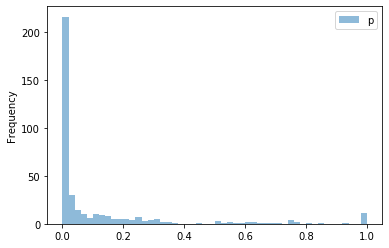

effectiveness: high


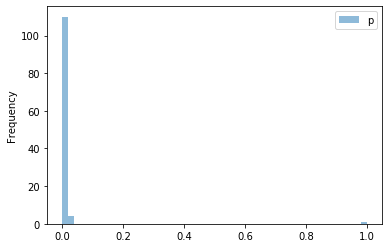

effectiveness: low


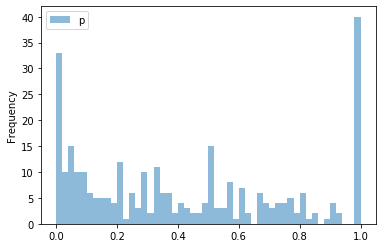

In [97]:
table1 = table[['effectiveness: total', 'p']]
for x in table1['effectiveness: total'].unique():
    print("effectiveness:", x)
    table1[table1['effectiveness: total'] == x].plot.hist(alpha=0.5, bins=50)
    plt.show()

The distributions aren't normal, I will need to take it into account when I'll conduct the test.

In [98]:
def check_hypothesis(group1, group2, alpha = 0.05):
    failure1 = table[table['effectiveness: total']==group1]['failures'].sum()
    failure2 = table[table['effectiveness: total']==group2]['failures'].sum()
    trials1 = table[table['effectiveness: total']==group1]['trials'].sum()
    trials2 = table[table['effectiveness: total']==group2]['trials'].sum()
    
    p1 = failure1/trials1

    p2 = failure2/trials2

    p_combined = (failure1 + failure2) / (trials1 + trials2)

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis for group", group1, "and group", group2)
    else:
        print("Failed to reject the null hypothesis for group", group1, "and group", group2)

In [99]:
check_hypothesis('high', 'medium', alpha = 0.05)
check_hypothesis('medium', 'low', alpha = 0.05)
check_hypothesis('high', 'low', alpha = 0.05)

p-value:  0.0
Rejecting the null hypothesis for group high and group medium
p-value:  0.0
Rejecting the null hypothesis for group medium and group low
p-value:  0.0
Rejecting the null hypothesis for group high and group low


As expected, acrroding to the test result we can reject the null hypothesis (that the percentage of missed incoming calls is the same) for all groups.

<a id="17"></a>
## Testing second hypothesis

Null hypothesis = Ineffective Operators and effective Operators have the same percentage of waiting time for incoming calls.

In [100]:
percentage_call_duration = percentage_call_duration.merge(operators_final, on="operator_id", how="left")
percentage_call_duration['waiting_time_per_call'] = percentage_call_duration['total_call_duration_per_call'] - percentage_call_duration['call_duration_per_call']
display(percentage_call_duration.head())

,operator_id,total_call_duration_per_call,call_duration_per_call,percentage_waiting_time,general_percentage,distance_from_mean,effectiveness,effectiveness: total,waiting_time_per_call
0,879896,1972.77193,1696.451754,14.006696,13.738425,0.268271,2,medium,276.320175
1,879898,4521.80000,3726.233333,17.594026,13.738425,3.855601,1,medium,795.566667
2,880020,353.00000,299.000000,15.297450,13.738425,1.559025,2,medium,54.000000
3,880022,624.00000,512.000000,17.948718,13.738425,4.210293,1,medium,112.000000
4,880026,1127.00000,1020.166667,9.479444,13.738425,-4.258981,3,high,106.833333


In [101]:
table = percentage_call_duration[['effectiveness: total', 'waiting_time_per_call', 'total_call_duration_per_call']]
table = table.rename(columns={'waiting_time_per_call': 'failures', 'total_call_duration_per_call': 'trials'})
display(table.head())

,effectiveness: total,failures,trials
0,medium,276.320175,1972.77193
1,medium,795.566667,4521.80000
2,medium,54.000000,353.00000
3,medium,112.000000,624.00000
4,high,106.833333,1127.00000


In [102]:
table['p'] = table['failures']/table['trials']
display(table.head())

,effectiveness: total,failures,trials,p
0,medium,276.320175,1972.77193,0.140067
1,medium,795.566667,4521.80000,0.175940
2,medium,54.000000,353.00000,0.152975
3,medium,112.000000,624.00000,0.179487
4,high,106.833333,1127.00000,0.094794


effectiveness: medium


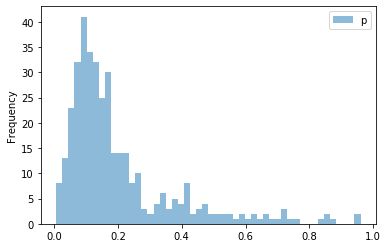

effectiveness: high


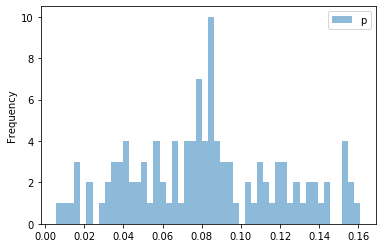

effectiveness: low


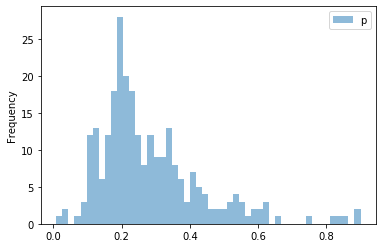

In [103]:
table1 = table[['effectiveness: total', 'p']]
for x in table1['effectiveness: total'].unique():
    print("effectiveness:", x)
    table1[table1['effectiveness: total'] == x].plot.hist(alpha=0.5, bins=50)
    plt.show()

The distributions aren't normal.

In [104]:
check_hypothesis('high', 'medium', alpha = 0.05)
check_hypothesis('medium', 'low', alpha = 0.05)
check_hypothesis('high', 'low', alpha = 0.05)

p-value:  0.0
Rejecting the null hypothesis for group high and group medium
p-value:  0.0
Rejecting the null hypothesis for group medium and group low
p-value:  0.0
Rejecting the null hypothesis for group high and group low


The Null hypothesis, that ineffective Operators and effective Operators have the same percentage of waiting time for incoming calls, was rejected in every combination. We have significant difference between the 3 groups.

<a id="18"></a>
## Testing third hypothesis

Null hypothesis = For operators that supposed to make outgoing calls, Ineffective Operators and effective Operators have the same percentage of outgoing calls.

In [105]:
percentage_outgoing_calls = percentage_outgoing_calls.merge(operators_final, on="operator_id", how="left")
display(percentage_outgoing_calls.head())

,operator_id,outgoing_calls_count,total_calls_count,percentage_outgoing_calls,general_percentage,distance_from_mean,effectiveness,effectiveness: total
0,879896,811,926,87.580994,79.421077,8.159916,2,medium
1,879898,7035,7196,97.762646,79.421077,18.341569,2,medium
2,880020,34,45,75.555556,79.421077,-3.865522,1,medium
3,880022,170,193,88.082902,79.421077,8.661824,2,medium
4,880026,2188,2232,98.028674,79.421077,18.607597,2,high


In [106]:
table = percentage_outgoing_calls[['effectiveness: total', 'outgoing_calls_count', 'total_calls_count']]
table = table.rename(columns={'outgoing_calls_count': 'success', 'total_calls_count': 'trials'})
display(table.head())

,effectiveness: total,success,trials
0,medium,811,926
1,medium,7035,7196
2,medium,34,45
3,medium,170,193
4,high,2188,2232


In [107]:
table['p'] = table['success']/table['trials']
display(table.head())

,effectiveness: total,success,trials,p
0,medium,811,926,0.875810
1,medium,7035,7196,0.977626
2,medium,34,45,0.755556
3,medium,170,193,0.880829
4,high,2188,2232,0.980287


effectiveness: medium


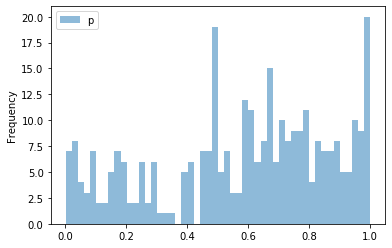

effectiveness: high


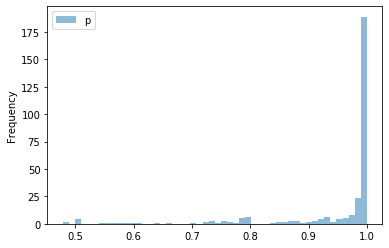

effectiveness: low


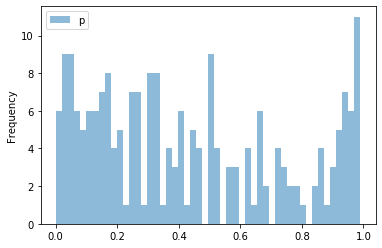

In [108]:
table1 = table[['effectiveness: total', 'p']]
for x in table1['effectiveness: total'].unique():
    print("effectiveness:", x)
    table1[table1['effectiveness: total'] == x].plot.hist(alpha=0.5, bins=50)
    plt.show()

The distributions aren't normal.

In [109]:
def check_hypothesis(group1, group2, alpha = 0.05):
    success1 = table[table['effectiveness: total']==group1]['success'].sum()
    success2 = table[table['effectiveness: total']==group2]['success'].sum()
    trials1 = table[table['effectiveness: total']==group1]['trials'].sum()
    trials2 = table[table['effectiveness: total']==group2]['trials'].sum()
    
    p1 = success1/trials1

    p2 = success2/trials2

    p_combined = (success1 + success2) / (trials1 + trials2)

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis for group", group1, "and group", group2)
    else:
        print("Failed to reject the null hypothesis for group", group1, "and group", group2)

In [110]:
check_hypothesis('high', 'medium', alpha = 0.05)
check_hypothesis('medium', 'low', alpha = 0.05)
check_hypothesis('high', 'low', alpha = 0.05)

p-value:  0.0
Rejecting the null hypothesis for group high and group medium
p-value:  0.0
Rejecting the null hypothesis for group medium and group low
p-value:  0.0
Rejecting the null hypothesis for group high and group low


The Null hypothesis, that for operators that supposed to make outgoing calls, Ineffective Operators and effective Operators have the same percentage of outgoing calls, was rejected in every combination. We have significant difference between the 3 groups.
so far so good!

<a id="19"></a>
## Testing final hypothesis

Null hypothesis: The mean lifetime of customers of ineffective operators is the same as the mean lifetime of customers of effective operators.
Alternative hypothesis: The mean lifetime of customers of ineffective operators is different than the mean lifetime of customers of effective operators.

In [111]:
dataset.shape

(42691, 11)

In [112]:
dataset = dataset.merge(operators_final, on=['operator_id'], how='left')
display(dataset.shape)

(42691, 12)

In [113]:
dataset = dataset.merge(clients, on=['user_id'], how='left')
display(dataset.shape)

(42691, 14)

In [114]:
dataset.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_duration_per_call,total_call_duration_per_call,effectiveness: total,tariff_plan,date_start
0,166377,2019-08-04,out,True,880022,True,3,0,5,0.0,1.666667,medium,B,2019-08-01
1,166377,2019-08-04,out,True,880020,True,1,0,1,0.0,1.000000,medium,B,2019-08-01
2,166377,2019-08-04,out,True,880020,False,1,10,18,10.0,18.000000,medium,B,2019-08-01
3,166377,2019-08-04,out,False,880022,True,3,0,25,0.0,8.333333,medium,B,2019-08-01
4,166377,2019-08-04,out,False,880020,False,2,3,29,1.5,14.500000,medium,B,2019-08-01


In [115]:
dataset['effectiveness: total'].value_counts()

medium    21920
low       10499
high      10272
Name: effectiveness: total, dtype: int64

In [116]:
dataset['costumer_lifetime'] = dataset['date'] - dataset['date_start']
dataset['costumer_lifetime'] = dataset['costumer_lifetime'] / pd.to_timedelta(1, unit='D')
display(dataset.head(5))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_duration_per_call,total_call_duration_per_call,effectiveness: total,tariff_plan,date_start,costumer_lifetime
0,166377,2019-08-04,out,True,880022,True,3,0,5,0.0,1.666667,medium,B,2019-08-01,3.0
1,166377,2019-08-04,out,True,880020,True,1,0,1,0.0,1.000000,medium,B,2019-08-01,3.0
2,166377,2019-08-04,out,True,880020,False,1,10,18,10.0,18.000000,medium,B,2019-08-01,3.0
3,166377,2019-08-04,out,False,880022,True,3,0,25,0.0,8.333333,medium,B,2019-08-01,3.0
4,166377,2019-08-04,out,False,880020,False,2,3,29,1.5,14.500000,medium,B,2019-08-01,3.0


In [117]:
len(dataset[dataset['costumer_lifetime'] < 0])

117

In [118]:
dataset = dataset[dataset['costumer_lifetime'] >= 0]
display(dataset.shape)

(42574, 15)

In [119]:
costumer_lifetime = dataset.groupby('user_id').agg({'costumer_lifetime':'max'})
costumer_lifetime = costumer_lifetime.rename(columns={'costumer_lifetime': 'costumer_lifetime_final'})
display(costumer_lifetime.head())

,costumer_lifetime_final
user_id,
166377,118.0
166391,112.0
166392,118.0
166399,82.0
166405,117.0


In [120]:
dataset = dataset.merge(costumer_lifetime, on=['user_id'], how='left')
display(dataset.shape)

(42574, 16)

In [121]:
dataset.tail(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_duration_per_call,total_call_duration_per_call,effectiveness: total,tariff_plan,date_start,costumer_lifetime,costumer_lifetime_final
42569,168606,2019-11-07,in,False,957922,False,2,686,705,343.00,352.50,low,C,2019-10-31,7.0,10.0
42570,168606,2019-11-08,out,False,957922,False,4,551,593,137.75,148.25,low,C,2019-10-31,8.0,10.0
42571,168606,2019-11-09,out,True,957922,False,1,0,25,0.00,25.00,low,C,2019-10-31,9.0,10.0
42572,168606,2019-11-09,out,True,957922,True,1,0,38,0.00,38.00,low,C,2019-10-31,9.0,10.0
42573,168606,2019-11-10,out,True,957922,False,2,479,501,239.50,250.50,low,C,2019-10-31,10.0,10.0


In [122]:
table = dataset[['operator_id','effectiveness: total', 'costumer_lifetime_final', 'user_id']]
table = table.drop_duplicates()
display(table.head())

,operator_id,effectiveness: total,costumer_lifetime_final,user_id
0,880022,medium,118.0,166377
1,880020,medium,118.0,166377
6,881278,medium,118.0,166377
10,880028,high,118.0,166377
11,880026,high,118.0,166377


In [123]:
table1 = table.drop(['operator_id', 'user_id'], axis = 1)
display(table1.head())

,effectiveness: total,costumer_lifetime_final
0,medium,118.0
1,medium,118.0
6,medium,118.0
10,high,118.0
11,high,118.0


effectiveness: medium


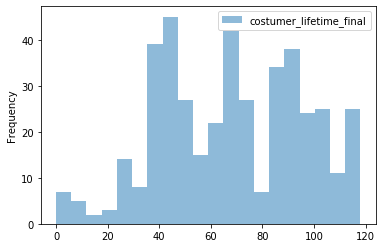

effectiveness: high


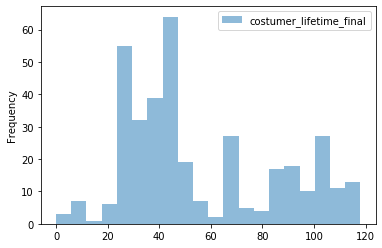

effectiveness: low


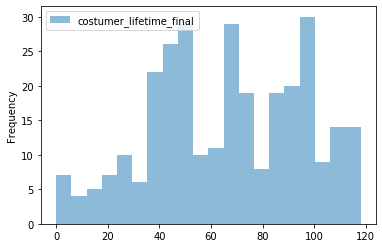

In [124]:
for x in table1['effectiveness: total'].unique():
    print("effectiveness:", x)
    table1[table1['effectiveness: total'] == x].plot.hist(alpha=0.5, bins=20)
    plt.show()

The distributions aren't normal.

In [125]:
table1 = table1.groupby('effectiveness: total')['costumer_lifetime_final'].mean().reset_index()
display(table1.head())

,effectiveness: total,costumer_lifetime_final
0,high,56.256131
1,low,66.351171
2,medium,68.252381


Surprising results: the mean lifetime for customers of operators with high effectiveness is lower than any other group. Nevertheless, the mean lifetime for customers of operators with medium effectiveness is higher than the mean lifetime for customers of operators with low effectiveness. But we still need to check if the difference is significant:

In [126]:
table.head()

,operator_id,effectiveness: total,costumer_lifetime_final,user_id
0,880022,medium,118.0,166377
1,880020,medium,118.0,166377
6,881278,medium,118.0,166377
10,880028,high,118.0,166377
11,880026,high,118.0,166377


In [127]:
sample_A = table[table['effectiveness: total']=='high']['costumer_lifetime_final']
sample_B = table[table['effectiveness: total']=='medium']['costumer_lifetime_final']
sample_C = table[table['effectiveness: total']=='low']['costumer_lifetime_final']

In [128]:
def check_hypothesis_mannwhitneyu(group1, group2, alpha = 0.05):
    results = st.mannwhitneyu(group1, group2)
    print('p-value: ', results.pvalue)
    if (results.pvalue < alpha):
        print("Null hypothesis rejected: the difference is statistically significant")
    else:
        print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 

In [129]:
check_hypothesis_mannwhitneyu(sample_A, sample_B, alpha = 0.05) 
check_hypothesis_mannwhitneyu(sample_B, sample_C, alpha = 0.05) 
check_hypothesis_mannwhitneyu(sample_A, sample_C, alpha = 0.05) 

p-value:  6.171404983358988e-11
Null hypothesis rejected: the difference is statistically significant
p-value:  0.25540051297155847
Failed to reject the null hypothesis: we can't make conclusions about the difference
p-value:  1.6962890939370386e-07
Null hypothesis rejected: the difference is statistically significant


The Null hypothesis, that the mean lifetime of customers of ineffective operators is the same as the mean lifetime of customers of effective operators, was rejected for high&mediumn effectiveness groups, and for high&low effectiveness groups. 
The Null hypothesis wasn't regected for low&mediumn effectiveness groups.
That means that we can say that there are significant differences in the mean lifetime between groups high&mediumn and high&low, but we can't say there is significant difference between groups medium&low. 
My concern came true, the mean lifetime of customers of ineffective operators ("low" group and even "medium" group) is  higher than the mean lifetime of customers of effective operators ("high" group). 

<a id="20"></a>
## Conclusion and recomedations

In this project I tried to identify ineffective operators. I divided the operators into 3 groups of effectiveness: high, medium and low, base on their missed incoming calls number, waiting time for incoming calls and number of outgoing calls (only for the operators that are supposed to make outgoing calls).
In the second part I conducted statistical tests to check if my identification is valid, and the differendes between the groups are significant. The differences between the groups were indeed significant.
Then I tested my final hypothesis, that the mean lifetime of customers of ineffective operators is the same as the mean lifetime of customers of effective operators. The results were significant and shocking: the mean lifetime of customers of ineffective operators ("low effectiveness" group and even "medium effectiveness" group) is  higher than the mean lifetime of customers of effective operators ("high effectiveness" group).
The results do not make sense, unless the risky customers classified somehow to the effective operators, in order to encourage  them to stay. 
In conclusion, I managed to identify the ineffective operators but I could not prove that ineffective operators make customer leave sooner.

<a id="21"></a>
# Dashboard

https://public.tableau.com/profile/avital6640#!/vizhome/FinalProject_16174541210690/Dashboard?publish=yes

<a id="23"></a>
# Presentation

https://drive.google.com/file/d/1JWXEJqqsDv91aUYZXbmBQxAeOVaBsIyJ/view?usp=sharing